In [30]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [31]:
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
from PIL import Image

from tensorflow import keras

In [33]:
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
IMAGE_SIZE = (256,256)

data_dir = '/content/drive/MyDrive/For_Colab/chest_xray'

batch_size = 64

epochs = 20

In [36]:
# Creating image data generator
image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                                                height_shift_range=0.1, rescale=1/255,
                                                shear_range=0.2, zoom_range=0.2,
                                                horizontal_flip=True, fill_mode='nearest')

In [37]:
train_gen = image_gen.flow_from_directory(os.path.join(data_dir,'train'),
                                         target_size=IMAGE_SIZE,
                                         batch_size=batch_size,
                                         class_mode='binary',
                                         shuffle=True)

Found 5216 images belonging to 2 classes.


In [38]:
test_gen = image_gen.flow_from_directory(os.path.join(data_dir,'test'),
                                         target_size=IMAGE_SIZE,
                                         batch_size=batch_size,
                                         class_mode='binary',
                                         shuffle=False)

Found 624 images belonging to 2 classes.


In [39]:
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [40]:
unique, counts = np.unique(train_gen.classes, return_counts=True)
dict(zip(unique, counts))

{0: 1341, 1: 3875}

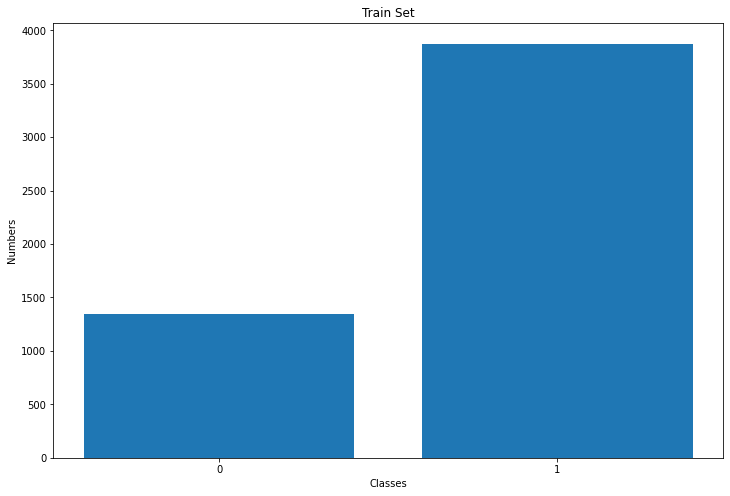

In [41]:
count_dict = dict(zip(unique, counts))
plt.figure(figsize=(12,8))
plt.bar(range(len(count_dict)), count_dict.values())
plt.xticks(range(len(count_dict)), count_dict.keys())
plt.ylabel('Numbers')
plt.xlabel('Classes')
plt.title('Train Set')
plt.show()

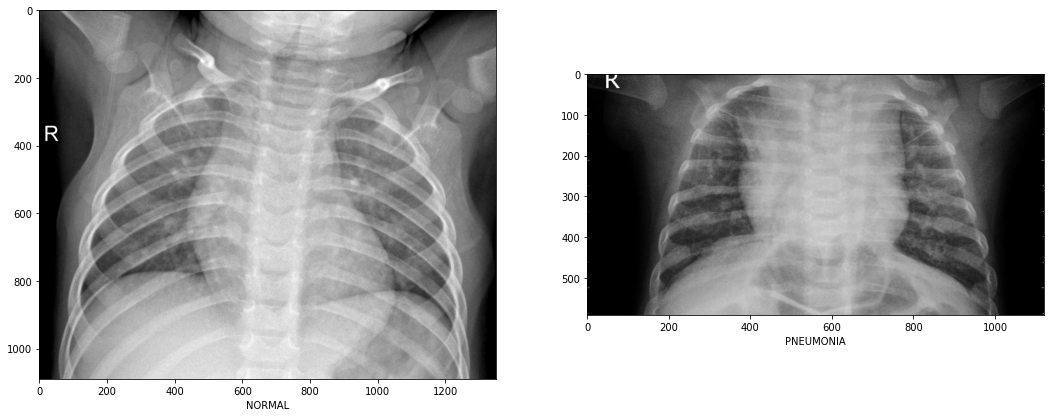

In [42]:
# Random Image
class_names = ['NORMAL', 'PNEUMONIA']
images = []
path = os.path.join(data_dir, 'train')
for i, cn in enumerate(class_names):
    image_names = os.listdir(os.path.join(path, cn))
    file_path = random.choice(image_names)
    images.append(Image.open(os.path.join(path, cn, file_path)))
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.xlabel(class_names[0])
plt.imshow(images[0], cmap='gray')
plt.subplot(122)
plt.xlabel(class_names[1])
plt.imshow(images[1], cmap='gray')
plt.show()

In [43]:
# Creating model
model = Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))


model.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))


model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))


model.add(layers.Flatten())


model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [44]:
model.build((batch_size,)+IMAGE_SIZE + (3,))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (64, 256, 256, 16)        448       
_________________________________________________________________
conv2d_31 (Conv2D)           (64, 256, 256, 16)        2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (64, 128, 128, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (64, 128, 128, 32)        4640      
_________________________________________________________________
conv2d_33 (Conv2D)           (64, 128, 128, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (64, 64, 64, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (64, 64, 64, 64)         

In [45]:
def scheduler(epoch, lr):
    if epoch < 10:
        return 0.0001
    else:
        return 0.00001

early_stop = EarlyStopping(monitor='val_loss', patience=4)
model_save = ModelCheckpoint('/content/drive/MyDrive/For_Colab/chest_xray/', monitor='val_accuracy',
                            save_best_only=True, save_weights_only=True,
                            mode='max')
lr_scheduler = LearningRateScheduler(scheduler)

In [46]:
model_history = model.fit(train_gen, epochs=epochs,
                         verbose=1, validation_data=test_gen,
                         callbacks=[early_stop, model_save, lr_scheduler])

Epoch 1/20
82/82 [==============================] - 133s 2s/step - loss: 0.5896 - accuracy: 0.7290 - val_loss: 0.5512 - val_accuracy: 0.8093
Epoch 2/20
82/82 [==============================] - 132s 2s/step - loss: 0.3187 - accuracy: 0.8509 - val_loss: 0.4745 - val_accuracy: 0.8221
Epoch 3/20
82/82 [==============================] - 131s 2s/step - loss: 0.2991 - accuracy: 0.8707 - val_loss: 0.5523 - val_accuracy: 0.7949
Epoch 4/20
82/82 [==============================] - 129s 2s/step - loss: 0.2526 - accuracy: 0.8938 - val_loss: 0.4500 - val_accuracy: 0.8317
Epoch 5/20
82/82 [==============================] - 132s 2s/step - loss: 0.2448 - accuracy: 0.9020 - val_loss: 0.3815 - val_accuracy: 0.8606
Epoch 6/20
82/82 [==============================] - 131s 2s/step - loss: 0.2133 - accuracy: 0.9091 - val_loss: 0.4449 - val_accuracy: 0.8349
Epoch 7/20
82/82 [==============================] - 129s 2s/step - loss: 0.1909 - accuracy: 0.9175 - val_loss: 0.3513 - val_accuracy: 0.8670
Epoch 8/20
82

In [50]:
model.load_weights('/content/drive/MyDrive/For_Colab/chest_xray/')

print('Test Score:', model.evaluate(test_gen))

10/10 [==============================] - 13s 1s/step - loss: 0.3914 - accuracy: 0.8718
Test Score: [0.39138728380203247, 0.8717948794364929]


In [60]:
print(*model.predict_classes(test_gen))

[0] [0] [1] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [1] [1] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [1] [1] [1] [0] [0] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [1] [0] [0] [1] [0] [1] [0] [0] [0] [0] [0] [1] [0] [1] [0] [0] [1] [1] [0] [0] [0] [1] [1] [1] [0] [1] [0] [1] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [0] [0] [0] [1] [0] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [0] [1] [0] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [0] [1] [1] [1] [1] [1] [1] [1] [0] [0] [0] [0] [1] [0] [0] [1] [0] [0] [0] [1] [0] [0] [1] [0] [0] [1] [0] [0] [0] [0] [1] [0] [0] [1] [0] [0] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [0] [0] [1] [0] [0] [1] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [0] [1] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [1] [1] [1] [0] [0] [0] [0] [0] [0] [0] [1] [1] [0] [1] [1] [1] [0] [0] [0] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] 

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict_classes(test_gen)
y_true = test_gen.classes
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80       234
           1       0.85      0.95      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624



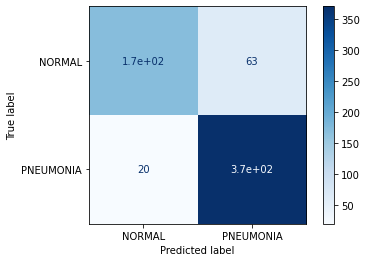

In [57]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap='Blues')

In [58]:
model.save("/content/drive/MyDrive/For_Colab/chest_xray/model1.h5")